In [ ]:
pip install torch--geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.4 MB/s eta 0:00:00


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import networkx as nx

In [ ]:
class ConvexLayer(nn.Module):
    """A convex layer that ensures convexity with respect to inputs."""
    def __init__(self, in_dim, out_dim):
        super(ConvexLayer, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(out_dim, in_dim))
        self.bias = nn.Parameter(torch.Tensor(out_dim))
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights to be non-negative to ensure convexity
        nn.init.uniform_(self.weight, 0.0, 0.1)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        # Using ReLU to maintain non-negativity of weights
        return F.linear(x, F.relu(self.weight), self.bias)


In [ ]:

class ConvexLayerICNN(nn.Module):
    """
    Input-Convex Neural Network constructed using ConvexLayer modules
    """
    def __init__(self, input_dim, hidden_dims, output_dim=1):
        super(ConvexLayerICNN, self).__init__()
        self.input_dim = input_dim

        # Build primary layers (no bias, weights must be non-negative)
        self.primary_layers = nn.ModuleList()

        # Build skip connections (with bias, no constraints on weights)
        self.skip_layers = nn.ModuleList()

        # Input dimension to first hidden dimension
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            # Primary path (using ConvexLayer to ensure non-negative weights)
            self.primary_layers.append(ConvexLayer(prev_dim, hidden_dim))

            # Skip connection from input (regular Linear layer)
            self.skip_layers.append(nn.Linear(input_dim, hidden_dim))

            prev_dim = hidden_dim

        # Output layer
        self.output_primary = ConvexLayer(prev_dim, output_dim)
        self.output_skip = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # Store original input for skip connections
        x0 = x

        # First hidden layer
        z = F.relu(self.primary_layers[0](x) + self.skip_layers[0](x0))

        # Subsequent hidden layers
        for i in range(1, len(self.primary_layers)):
            z = F.relu(self.primary_layers[i](z) + self.skip_layers[i](x0))

        # Output layer
        out = self.output_primary(z) + self.output_skip(x0)

        return out


In [ ]:

class ConvexMessagePassing(MessagePassing):
    """Message passing layer that maintains input convexity."""
    def __init__(self, in_channels, hidden_dims, out_channels):
        super(ConvexMessagePassing, self).__init__(aggr='add')
        self.convex_transform = ConvexLayerICNN(in_channels, hidden_dims, out_channels)

    def forward(self, x, edge_index):
        # Propagate messages
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # Transform messages in a convex manner
        return self.convex_transform(x_j)

    def update(self, aggr_out):
        # No additional transformation needed here
        return aggr_out

In [ ]:

class ICGRNN(nn.Module):
    """Input Convex Graph Recurrent Neural Network using ConvexLayerICNN."""
    def __init__(self, input_dim, hidden_dim, output_dim, icnn_hidden_dims=[32, 32]):
        super(ICGRNN, self).__init__()
        self.hidden_dim = hidden_dim

        # Input-to-hidden convex transformation
        self.ih = ConvexLayerICNN(input_dim, icnn_hidden_dims, hidden_dim)

        # Hidden-to-hidden convex transformation
        self.hh = ConvexLayerICNN(hidden_dim, icnn_hidden_dims, hidden_dim)

        # Message passing layer
        self.message_passing = ConvexMessagePassing(hidden_dim, icnn_hidden_dims, hidden_dim)

        # Output layer
        self.output_layer = ConvexLayerICNN(hidden_dim, icnn_hidden_dims, output_dim)

    def forward(self, x, edge_index, h=None, steps=1):
        num_nodes = x.size(0) if x.dim() == 2 else x.size(1)

        # Initialize hidden state if not provided
        if h is None:
            h = torch.zeros(num_nodes, self.hidden_dim, device=x.device)

        outputs = []

        for t in range(steps):
            # Apply input transformation

            # print(x.shape) ##########################################################################################
            input_transform = self.ih(x)

            # Apply hidden transformation
            hidden_transform = self.hh(h)

            # Combine and apply activation
            combined = input_transform + hidden_transform
            h_tilde = F.relu(combined)  # ReLU maintains convexity

            # Apply message passing
            h = self.message_passing(h_tilde, edge_index)

            # Compute output for this time step
            out = self.output_layer(h)
            outputs.append(out)

        # Stack outputs for all time steps
        return torch.stack(outputs, dim=1), h



In [ ]:

def train_icgrnn(model, graph_data, target, num_epochs=100, lr=0.01):
    """
    Train the ICGRNN model with gradient clipping and diagnostics.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # If target is for the final step only
    final_step_only = (len(target.shape) == 2)

    for epoch in range(num_epochs):
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass with diagnostic checks
        try:
            output, hidden = model(graph_data.x, graph_data.edge_index,
                                  steps=target.shape[1] if not final_step_only else 1)

            # Check for NaN in forward pass
            if torch.isnan(output).any():
                print(f"Epoch {epoch+1}: NaN in output detected")
                # We could try to identify which component is generating NaNs here
                continue

            # Compute loss
            if final_step_only:
                # If target is only for the final time step
                loss = F.mse_loss(output[:, -1, :], target)
            else:
                # If target is for all time steps
                loss = F.mse_loss(output, target)

            # Check for NaN loss
            if torch.isnan(loss):
                print(f"Epoch {epoch+1}: NaN loss detected, skipping update")
                continue

            # Backward pass
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update parameters
            optimizer.step()

            # Print progress
            if (epoch+1) % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}')

        except Exception as e:
            print(f"Epoch {epoch+1}: Error during training: {e}")
            continue

    return model

# Training-1 Sample Tensors

In [ ]:


torch.manual_seed(42)

# Create a simple graph
edge_index = torch.tensor([[0, 1, 1, 2],
                          [1, 0, 2, 1]], dtype=torch.long)

# Create node features with small values for stability
x = torch.randn(3, 8) * 0.1  # 3 nodes, 8 features, scaled for stability

# Create a PyG Data object
graph_data = Data(x=x, edge_index=edge_index)

# Create synthetic targets with small values for stability
target = torch.randn(3, 5, 4) * 0.1  # [num_nodes, num_steps, output_dim]

print("Input features range:", torch.min(x).item(), "to", torch.max(x).item())
print("Target values range:", torch.min(target).item(), "to", torch.max(target).item())

# Initialize model with smaller hidden dimensions
model = ICGRNN(input_dim=8, hidden_dim=16, output_dim=4, icnn_hidden_dims=[16, 16])

# Test forward pass before training
print("\nTesting initial forward pass:")
try:
    with torch.no_grad():
        initial_output, _ = model(graph_data.x, graph_data.edge_index, steps=5)
        print("Forward pass successful")
        print("Initial output shape:", initial_output.shape)
        print("Initial output range:",
              torch.min(initial_output).item(), "to",
              torch.max(initial_output).item())
except Exception as e:
    print(f"Error in initial forward pass: {e}")

# Train the model
print("\nStarting training:")
# Train with a lower learning rate for stability
trained_model = train_icgrnn(model, graph_data, target, num_epochs=100, lr=0.005)

# Make predictions with the trained model
print("\nFinal prediction:")
try:
    with torch.no_grad():
        predictions, _ = trained_model(graph_data.x, graph_data.edge_index, steps=5)
        print("Predictions shape:", predictions.shape)
        print("Predictions range:",
              torch.min(predictions).item(), "to",
              torch.max(predictions).item())

        # Compute final error
        final_error = F.mse_loss(predictions, target).item()
        print(f"Final MSE: {final_error:.6f}")
except Exception as e:
    print(f"Error in final prediction: {e}")

Input features range: -0.23169226944446564 to 0.19269153475761414
Target values range: -0.1418059915304184 to 0.28140270709991455

Testing initial forward pass:
Forward pass successful
Initial output shape: torch.Size([3, 5, 4])
Initial output range: 0.02394329011440277 to 1.8028271198272705

Starting training:
Epoch 10/100, Loss: 0.012736
Epoch 20/100, Loss: 0.008640
Epoch 30/100, Loss: 0.008203
Epoch 40/100, Loss: 0.007500
Epoch 50/100, Loss: 0.007057
Epoch 60/100, Loss: 0.006805
Epoch 70/100, Loss: 0.006439
Epoch 80/100, Loss: 0.005862
Epoch 90/100, Loss: 0.005137
Epoch 100/100, Loss: 0.004645

Final prediction:
Predictions shape: torch.Size([3, 5, 4])
Predictions range: -0.12288177013397217 to 0.11777205020189285
Final MSE: 0.004591


# Heat diffusion problem

In [ ]:

def create_heat_diffusion_dataset(num_nodes=10, num_timesteps=20, num_samples=100, diffusion_rate=0.1):
    """
    Create synthetic data for heat diffusion with control inputs on a graph.

    Parameters:
    - num_nodes: Number of nodes in the graph
    - num_timesteps: Number of time steps to simulate
    - num_samples: Number of different initial conditions to generate
    - diffusion_rate: Rate of heat diffusion between connected nodes

    Returns:
    - graph_data: PyG Data object with the graph structure
    - features: Input features including initial temperatures and control signals
    - targets: Optimal temperature evolution under controlled diffusion
    """
    # Create a random connected graph
    # Using a cycle graph with some random edges for better connectivity
    G = nx.cycle_graph(num_nodes)

    # Add some random edges to make it more interesting
    for _ in range(num_nodes):
        i, j = np.random.randint(0, num_nodes, 2)
        if i != j:
            G.add_edge(i, j)

    # Convert to PyTorch Geometric format
    edge_index = torch.tensor(list(G.edges())).t().contiguous()
    # Add reverse edges to make it undirected
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

    # Create adjacency matrix for simulation
    adj_matrix = nx.to_numpy_array(G)

    # Initialize dataset containers
    features_list = []
    targets_list = []

    for sample in range(num_samples):
        # Initial temperature (random between 0 and 1)
        initial_temp = torch.rand(num_nodes, 1)

        # Target temperature (random between 0 and 1)
        target_temp = torch.rand(num_nodes, 1)

        # Initialize temperature trajectory and control inputs
        temp_trajectory = torch.zeros(num_nodes, num_timesteps)
        control_inputs = torch.zeros(num_nodes, num_timesteps)
        temp_trajectory[:, 0] = initial_temp.squeeze()

        # Simulate heat diffusion with simple control
        for t in range(1, num_timesteps):
            # Current temperature
            current_temp = temp_trajectory[:, t-1].numpy()

            # Compute diffusion (simplified heat equation on graph)
            diffusion = diffusion_rate * (adj_matrix @ current_temp - current_temp * np.sum(adj_matrix, axis=1))

            # Compute control input (simplified proportional control towards target)
            error = target_temp.numpy().squeeze() - current_temp
            control = 0.05 * error  # Proportional control factor

            # Apply diffusion and control
            next_temp = current_temp + diffusion + control

            # Store values
            temp_trajectory[:, t] = torch.tensor(next_temp)
            control_inputs[:, t-1] = torch.tensor(control)

        # Create input features: [initial_temp, target_temp]
        node_features = torch.cat([initial_temp, target_temp], dim=1)

        # Store this sample
        features_list.append(node_features)
        targets_list.append(torch.cat([temp_trajectory, control_inputs], dim=1))

    # Stack all samples
    features = torch.stack(features_list)  # [num_samples, num_nodes, 2]
    targets = torch.stack(targets_list)    # [num_samples, num_nodes, 2*num_timesteps]

    # Create PyG data object
    graph_data = Data(edge_index=edge_index)

    return graph_data, features, targets

In [ ]:
class HeatDiffusionICGRNN(nn.Module):
    """Input Convex Graph RNN for heat diffusion control with stability improvements."""
    def __init__(self, input_dim, hidden_dim, output_dim=1, icnn_hidden_dims=[32, 32]):
        super(HeatDiffusionICGRNN, self).__init__()
        self.hidden_dim = hidden_dim

        # Input-to-hidden convex transformation
        self.ih = ConvexLayerICNN(input_dim, icnn_hidden_dims, hidden_dim)

        # Hidden-to-hidden convex transformation
        self.hh = ConvexLayerICNN(hidden_dim, icnn_hidden_dims, hidden_dim)

        # Message passing layer
        self.message_passing = ConvexMessagePassing(hidden_dim, icnn_hidden_dims, hidden_dim)

        # Output layers - separated for temperature and control
        self.temp_output = ConvexLayerICNN(hidden_dim, icnn_hidden_dims, output_dim)
        self.control_output = ConvexLayerICNN(hidden_dim, icnn_hidden_dims, output_dim)

        # Add normalization layers for stability
        self.hidden_norm = nn.LayerNorm(hidden_dim)
        self.pre_temp_norm = nn.LayerNorm(hidden_dim)
        self.pre_control_norm = nn.LayerNorm(hidden_dim)

        # Initialize scaling factor for stability
        self.scale_factor = 0.1

    def forward(self, x, edge_index, h=None, steps=20):
        batch_size = 1 if x.dim() == 2 else x.size(0)
        num_nodes = x.size(-2)
        # print(batch_size)

        # Reshape if we have a batch dimension
        if x.dim() == 3:  # [batch, nodes, features]
            x_flat = x.reshape(-1, x.size(-1))
        else:  # [nodes, features]
            x_flat = x

        # Initialize hidden state if not provided
        if h is None:
            h = torch.zeros(batch_size * num_nodes, self.hidden_dim, device=x.device)

        temp_outputs = []
        control_outputs = []

        for t in range(steps):
            # Apply input with scaling for stability
            input_transform = self.scale_factor * self.ih(x_flat)

            # Apply hidden transformation with scaling for stability
            hidden_transform = self.scale_factor * self.hh(h)

            # Combine and apply activation
            combined = input_transform + hidden_transform
            h_tilde = F.relu(combined)  # ReLU maintains convexity

            # Apply message passing
            if batch_size > 1:
                # This is a simplification - in practice you'd use PyG's batch handling
                batched_edge_index = []
                for b in range(batch_size):
                    offset = b * num_nodes
                    batched_edge_index.append(edge_index + offset)
                batched_edge_index = torch.cat(batched_edge_index, dim=1)
                h_raw = self.message_passing(h_tilde, batched_edge_index)
            else:
                h_raw = self.message_passing(h_tilde, edge_index)
                # h_raw = self.message_passing(h_raw, edge_index)
                # h_raw = self.message_passing(h_raw, edge_index)

            # Apply normalization to hidden state for stability
            h = self.hidden_norm(h_raw)

            # Compute temperature output with normalization and clamping
            temp_out = self.temp_output(self.pre_temp_norm(h))
            # Clamp temperature values to reasonable range
            temp_out = torch.clamp(temp_out, min=0.0, max=100.0)
            # print(temp_out)
            # print("TempOut")
            temp_outputs.append(temp_out)

            # Compute control output with normalization and clamping
            control_out = self.control_output(self.pre_control_norm(h))
            # Clamp control values to reasonable range
            control_out = torch.clamp(control_out, min=-50.0, max=50.0)
            control_outputs.append(control_out)

        # Stack outputs for all time steps and reshape
        temp_tensor = torch.stack(temp_outputs, dim=1)  # [batch*nodes, steps, 1]
        control_tensor = torch.stack(control_outputs, dim=1)  # [batch*nodes, steps, 1]

        # Reshape to [batch, nodes, steps, 1] if we have a batch
        if batch_size > 1:
            temp_tensor = temp_tensor.view(batch_size, num_nodes, steps, 1)
            control_tensor = control_tensor.view(batch_size, num_nodes, steps, 1)
        else:
            temp_tensor = temp_tensor.view(num_nodes, steps, 1)
            control_tensor = control_tensor.view(num_nodes, steps, 1)

        # Squeeze the last dimension
        temp_tensor = temp_tensor.squeeze(-1)
        control_tensor = control_tensor.squeeze(-1)

        return temp_tensor, control_tensor, h

In [ ]:
def train_heat_diffusion_model(model, graph_data, features, targets, num_epochs=100, lr=0.001, weight_decay=1e-5, patience=15):
    """
    Train the heat diffusion model with improved stability measures.

    Parameters:
    - model: HeatDiffusionICGRNN model
    - graph_data: PyG Data object with graph structure
    - features: Input features
    - targets: Target temperature and control trajectories
    - num_epochs: Maximum number of training epochs
    - lr: Learning rate
    - weight_decay: L2 regularization factor
    - patience: Early stopping patience
    """
    # Initialize optimizer with weight decay
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler - reduce LR when loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5, verbose=True
    )

    num_samples = features.size(0)
    num_nodes = features.size(1)
    num_timesteps = targets.size(2) // 2

    # Separate temperature and control targets
    temp_targets = targets[:, :, :num_timesteps]  # [samples, nodes, timesteps]
    control_targets = targets[:, :, num_timesteps:]  # [samples, nodes, timesteps]

    # For early stopping
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        total_temp_loss = 0
        total_control_loss = 0

        # Process each sample
        for i in range(num_samples):
            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            temp_pred, control_pred, _ = model(features[i], graph_data.edge_index, steps=num_timesteps)

            # Compute losses
            temp_loss = F.mse_loss(temp_pred, temp_targets[i])
            control_loss = F.mse_loss(control_pred, control_targets[i])
            loss = temp_loss + 0.1 * control_loss  # Weighting factor for control loss

            # Check for NaN loss
            if torch.isnan(loss):
                print(f"Warning: NaN loss detected at epoch {epoch+1}, sample {i}")
                continue

            # Backward pass
            loss.backward()

            # Gradient clipping (critical for stability)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update parameters
            optimizer.step()

            # Accumulate losses
            total_loss += loss.item()
            total_temp_loss += temp_loss.item()
            total_control_loss += control_loss.item()

        # Calculate average losses
        avg_loss = total_loss / num_samples
        avg_temp_loss = total_temp_loss / num_samples
        avg_control_loss = total_control_loss / num_samples

        # Update learning rate based on average loss
        scheduler.step(avg_loss)

        # Print progress
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, '
                  f'Temp Loss: {avg_temp_loss:.4f}, Control Loss: {avg_control_loss:.4f}, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            # Save best model state
            best_model_state = {k: v.cpu().detach().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                # Restore best model
                model.load_state_dict(best_model_state)
                break

    return model

In [ ]:
print("Generating synthetic heat diffusion data...")

graph_data, features, targets = create_heat_diffusion_dataset(
    num_nodes=50, num_timesteps=20, num_samples=500, diffusion_rate=0.1
)

print(f"Generated dataset with {features.size(0)} samples")
print(f"Graph has {graph_data.edge_index.max().item() + 1} nodes and {graph_data.edge_index.size(1)//2} edges")
print(f"Feature shape: {features.shape}, Target shape: {targets.shape}")

model = HeatDiffusionICGRNN(
    input_dim=features.size(-1),  # Input dimension from dataset
    hidden_dim=32,                # Hidden dimension size
    output_dim=1,                 # Output dimension (typically 1 for temperature/control)
    icnn_hidden_dims=[32, 32,]     # Hidden dimensions in ICNNs
).to(device)

graph_data = graph_data.to(device)
features = features.to(device)
targets = targets.to(device)

Generating synthetic heat diffusion data...
Generated dataset with 500 samples
Graph has 50 nodes and 95 edges
Feature shape: torch.Size([500, 50, 2]), Target shape: torch.Size([500, 50, 40])


In [ ]:
device

device(type='cuda')

In [ ]:
# Train the model
print("\nTraining the model...")
model = train_heat_diffusion_model(
    model, graph_data, features, targets, num_epochs=50, lr=0.001
)


Training the model...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 10/50, Avg Loss: 0.0063, Temp Loss: 0.0063, Control Loss: 0.0001, LR: 0.001000
Epoch 20/50, Avg Loss: 0.0062, Temp Loss: 0.0062, Control Loss: 0.0001, LR: 0.001000
Epoch 30/50, Avg Loss: 0.0061, Temp Loss: 0.0061, Control Loss: 0.0001, LR: 0.001000
Epoch 40/50, Avg Loss: 0.0061, Temp Loss: 0.0061, Control Loss: 0.0001, LR: 0.001000
Epoch 50/50, Avg Loss: 0.0061, Temp Loss: 0.0061, Control Loss: 0.0001, LR: 0.001000


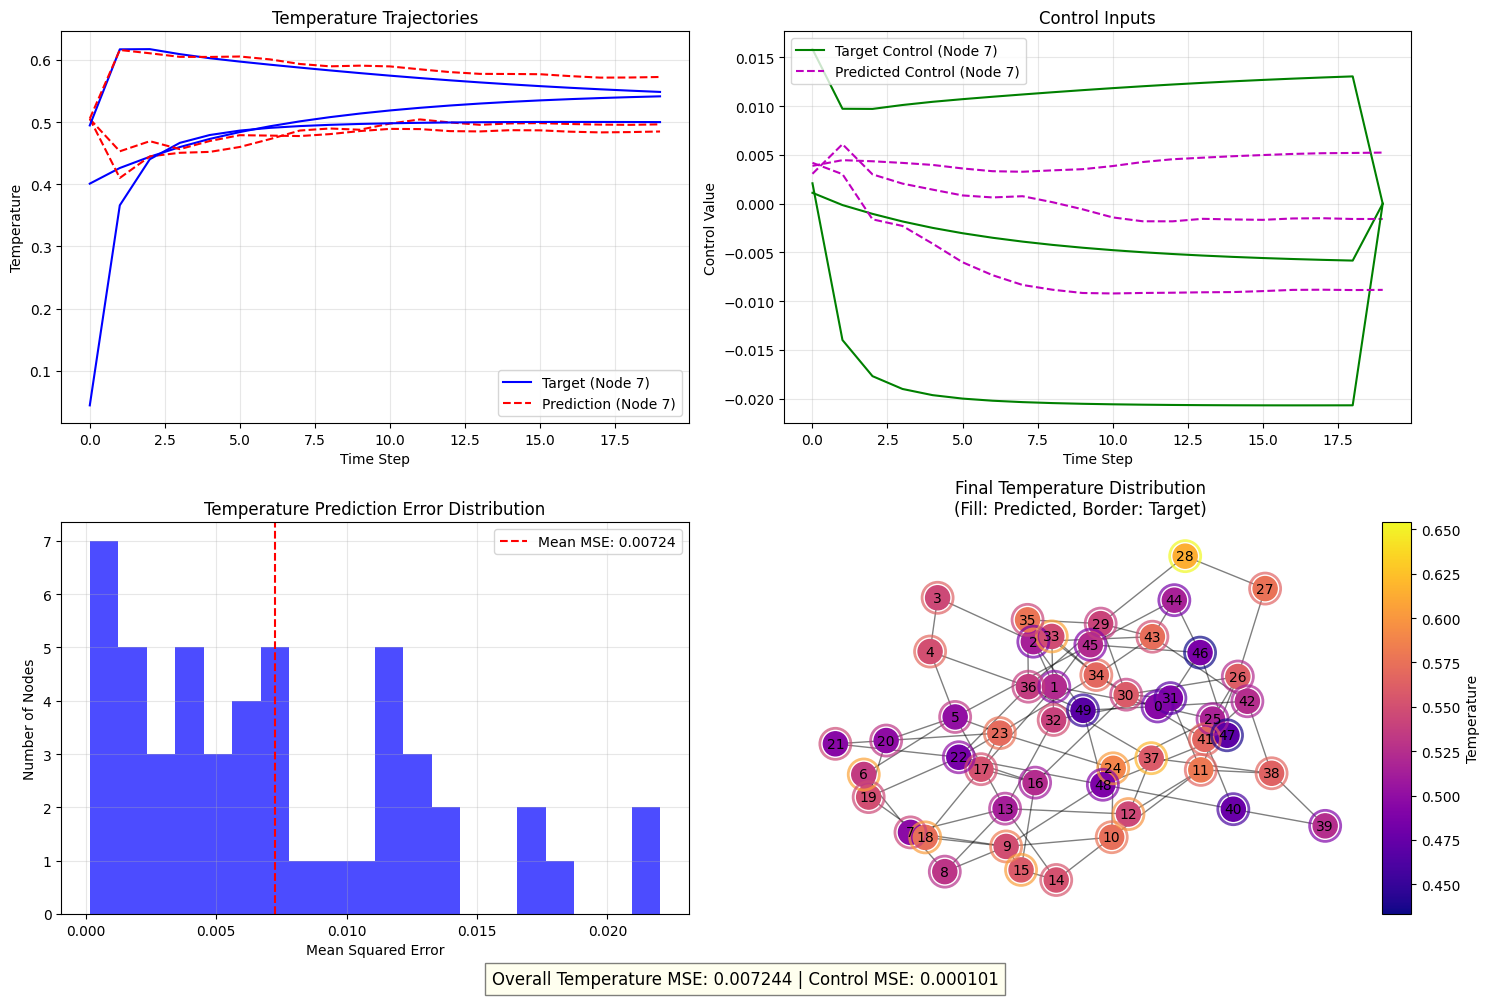

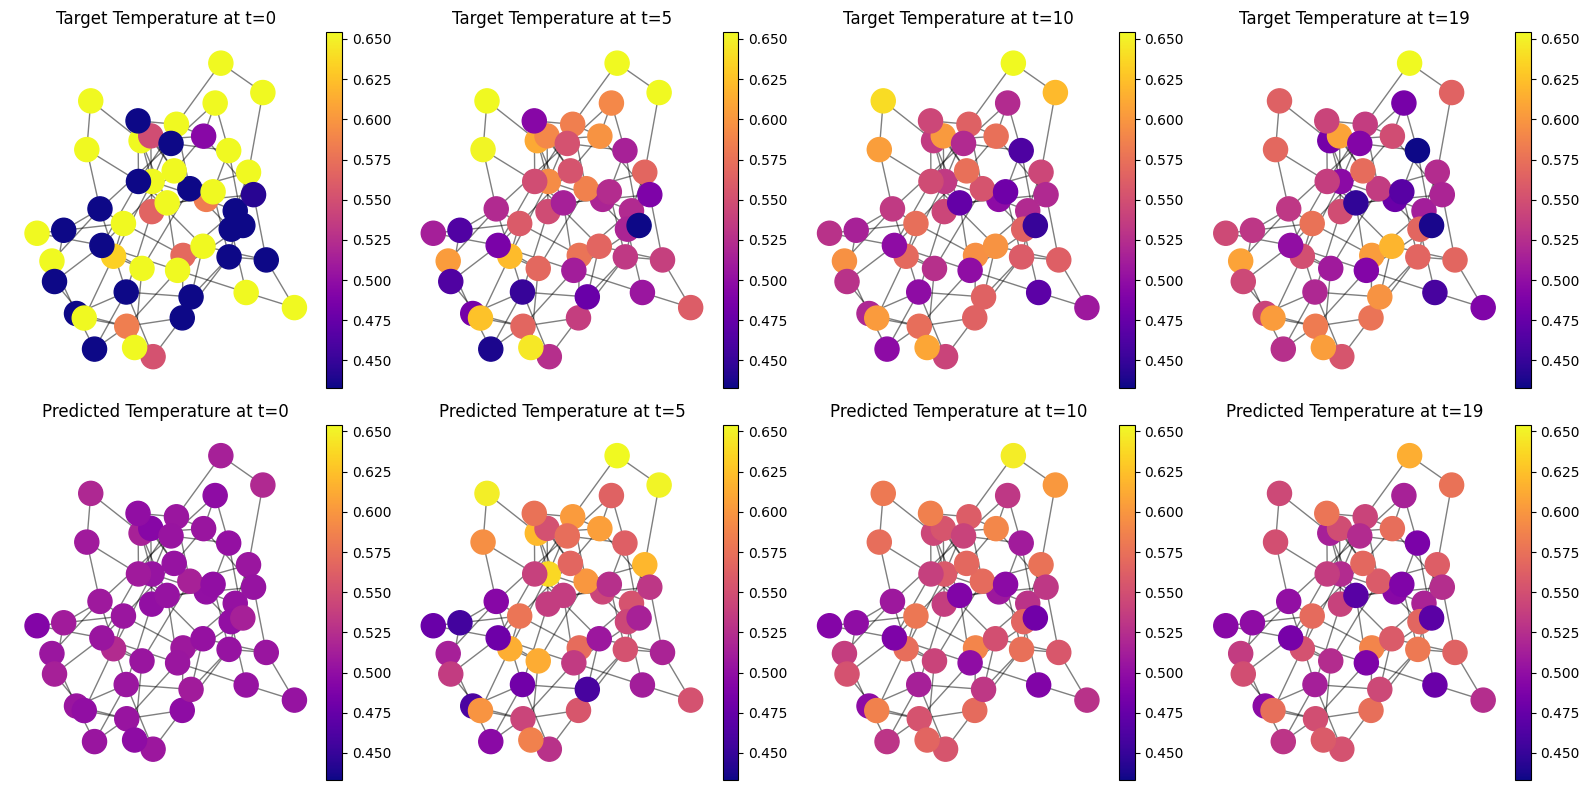

Temperature MSE: 0.007244
Control MSE: 0.000101


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from torch_geometric.utils import to_networkx
import torch

def visualize_model_performance(model, graph_data, features, targets, sample_idx=0, node_indices=None):
    """
    Visualize the performance of the heat diffusion model.

    Parameters:
    - model: Trained HeatDiffusionICGRNN model
    - graph_data: PyG Data object with graph structure
    - features: Input features [num_samples, num_nodes, input_dim]
    - targets: Target temperature and control trajectories [num_samples, num_nodes, 2*num_timesteps]
    - sample_idx: Index of the sample to visualize
    - node_indices: List of node indices to visualize (None for random selection)
    """
    # Set model to evaluation mode
    model.eval()

    # Get dimensions
    num_timesteps = targets.size(2) // 2
    num_nodes = features.size(1)

    # Separate temperature and control targets
    temp_targets = targets[:, :, :num_timesteps]  # [samples, nodes, timesteps]
    control_targets = targets[:, :, num_timesteps:]  # [samples, nodes, timesteps]

    # If no specific nodes provided, choose a few random ones
    if node_indices is None:
        node_indices = np.random.choice(num_nodes, size=min(3, num_nodes), replace=False)

    # Generate predictions
    with torch.no_grad():
        temp_pred, control_pred, _ = model(features[sample_idx], graph_data.edge_index, steps=num_timesteps)

    # Convert to numpy for plotting
    temp_targets_np = temp_targets[sample_idx].cpu().numpy()
    control_targets_np = control_targets[sample_idx].cpu().numpy()
    temp_pred_np = temp_pred.cpu().numpy()
    control_pred_np = control_pred.cpu().numpy()

    # Calculate errors
    temp_mse = np.mean((temp_targets_np - temp_pred_np) ** 2)
    control_mse = np.mean((control_targets_np - control_pred_np) ** 2)

    # 1. Plot temperature and control trajectories for selected nodes
    plt.figure(figsize=(15, 10))

    # Initial conditions and targets from features
    initial_temp = features[sample_idx, :, 0].cpu().numpy()
    target_temp = features[sample_idx, :, 1].cpu().numpy()

    # Temperature trajectories
    plt.subplot(2, 2, 1)
    for i in node_indices:
        plt.plot(temp_targets_np[i], 'b-', label=f'Target (Node {i})' if i == node_indices[0] else "")
        plt.plot(temp_pred_np[i], 'r--', label=f'Prediction (Node {i})' if i == node_indices[0] else "")

    plt.title('Temperature Trajectories')
    plt.xlabel('Time Step')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Control inputs
    plt.subplot(2, 2, 2)
    for i in node_indices:
        plt.plot(control_targets_np[i], 'g-', label=f'Target Control (Node {i})' if i == node_indices[0] else "")
        plt.plot(control_pred_np[i], 'm--', label=f'Predicted Control (Node {i})' if i == node_indices[0] else "")

    plt.title('Control Inputs')
    plt.xlabel('Time Step')
    plt.ylabel('Control Value')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Visualize error distributions
    plt.subplot(2, 2, 3)

    # Temperature error distribution across all nodes
    temp_errors = np.mean((temp_targets_np - temp_pred_np) ** 2, axis=1)  # MSE per node

    plt.hist(temp_errors, bins=20, alpha=0.7, color='blue')
    plt.axvline(x=np.mean(temp_errors), color='r', linestyle='--',
                label=f'Mean MSE: {np.mean(temp_errors):.5f}')
    plt.title('Temperature Prediction Error Distribution')
    plt.xlabel('Mean Squared Error')
    plt.ylabel('Number of Nodes')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Visualize the graph with temperature at final timestep
    plt.subplot(2, 2, 4)

    # Convert to networkx graph
    G = to_networkx(graph_data, to_undirected=True)

    # Get node positions using a layout algorithm
    pos = nx.spring_layout(G, seed=42)

    # Final temperatures (predicted and target)
    final_pred_temp = temp_pred_np[:, -1]
    final_target_temp = temp_targets_np[:, -1]

    # Normalize temperatures for color mapping
    vmin = min(np.min(final_pred_temp), np.min(final_target_temp))
    vmax = max(np.max(final_pred_temp), np.max(final_target_temp))

    # Draw predicted temperatures
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=final_pred_temp,
                          cmap=plt.cm.plasma, vmin=vmin, vmax=vmax,
                          label='Predicted')

    # Draw target temperatures as node borders
    node_border_colors = [final_target_temp[i] for i in range(num_nodes)]
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='none',
                          edgecolors=plt.cm.plasma(
                              (np.array(node_border_colors) - vmin) / (vmax - vmin + 1e-8)
                          ),
                          linewidths=2, alpha=0.7, label='Target')

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title('Final Temperature Distribution\n(Fill: Predicted, Border: Target)')
    plt.axis('off')

    # Add a colorbar
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, cax=cax, label='Temperature')

    # Add overall metrics
    plt.figtext(0.5, 0.01,
                f"Overall Temperature MSE: {temp_mse:.6f} | Control MSE: {control_mse:.6f}",
                ha="center", fontsize=12,
                bbox={"facecolor":"lightyellow", "alpha":0.5, "pad":5})

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08)
    plt.savefig('heat_diffusion_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Additional visualization: Temperature evolution over time
    plt.figure(figsize=(16, 8))

    # Select timesteps to visualize
    timesteps = [0, num_timesteps//4, num_timesteps//2, num_timesteps-1]

    for i, t in enumerate(timesteps):
        plt.subplot(2, len(timesteps), i+1)

        # Target temperature at timestep t
        nx.draw_networkx_nodes(G, pos, node_size=300,
                              node_color=temp_targets_np[:, t],
                              cmap=plt.cm.plasma, vmin=vmin, vmax=vmax)
        nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
        plt.title(f'Target Temperature at t={t}')
        plt.axis('off')

        # Add a colorbar
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        plt.colorbar(sm, cax=cax)

        plt.subplot(2, len(timesteps), i+len(timesteps)+1)

        # Predicted temperature at timestep t
        nx.draw_networkx_nodes(G, pos, node_size=300,
                              node_color=temp_pred_np[:, t],
                              cmap=plt.cm.plasma, vmin=vmin, vmax=vmax)
        nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
        plt.title(f'Predicted Temperature at t={t}')
        plt.axis('off')

        # Add a colorbar
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        plt.colorbar(sm, cax=cax)

    plt.tight_layout()
    plt.savefig('heat_diffusion_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()

    return temp_mse, control_mse


# Example usage:
# Visualize performance on the first sample
temp_mse, control_mse = visualize_model_performance(model, graph_data, features, targets, sample_idx=0)
print(f"Temperature MSE: {temp_mse:.6f}")
print(f"Control MSE: {control_mse:.6f}")

# If you want to visualize specific nodes, you can specify them:
# visualize_model_performance(model, graph_data, features, targets, sample_idx=0, node_indices=[0, 2, 5])

# CORA Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import accuracy_score, f1_score
from torch_geometric.data import Data

In [ ]:

class CoraNodeClassifier(nn.Module):
    """ICGRNN adapted for node classification on CORA dataset."""
    def __init__(self, input_dim, hidden_dim, num_classes, icnn_hidden_dims=[32, 32]):
        super(CoraNodeClassifier, self).__init__()
        self.hidden_dim = hidden_dim

        # Input-to-hidden convex transformation
        self.ih = ConvexLayerICNN(input_dim, icnn_hidden_dims, hidden_dim)

        # Hidden-to-hidden convex transformation
        self.hh = ConvexLayerICNN(hidden_dim, icnn_hidden_dims, hidden_dim)

        # Message passing layer
        self.message_passing = ConvexMessagePassing(hidden_dim, icnn_hidden_dims, hidden_dim)

        # Output layer (classifier)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        # Initialize hidden state
        h = torch.zeros(x.size(0), self.hidden_dim, device=x.device)

        # Process the graph recurrently for specified steps
        for t in range(5):
            # Apply input transformation
            input_transform = self.ih(x)

            # Apply hidden transformation
            hidden_transform = self.hh(h)

            # Combine and apply activation
            combined = input_transform + hidden_transform
            h_tilde = F.relu(combined)




            # Apply message passing
            h = self.message_passing(h_tilde, edge_index)
            h = F.dropout(h, p=0.5, training=self.training)

        # Final classification layer
        logits = self.classifier(h)

        return logits, h


def train_cora_model(model, data, num_epochs=200, lr=0.01):
    """
    Train the ICGRNN model on CORA dataset.

    Parameters:
    - model: CoraNodeClassifier model
    - data: PyG Data object containing CORA dataset
    - num_epochs: Number of training epochs
    - lr: Learning rate
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        # Training mode
        model.train()
        optimizer.zero_grad()

        # Forward pass
        logits, _ = model(data.x, data.edge_index)

        # Compute loss (only for training nodes)
        loss = criterion(logits[data.train_mask], data.y[data.train_mask])

        # Backward pass
        loss.backward()
        optimizer.step()

        # Evaluation mode
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                # Forward pass
                logits, _ = model(data.x, data.edge_index)
                pred = logits.argmax(dim=1)

                # Compute training, validation and test accuracies
                train_acc = accuracy_score(data.y[data.train_mask].cpu(),
                                          pred[data.train_mask].cpu())
                val_acc = accuracy_score(data.y[data.val_mask].cpu(),
                                        pred[data.val_mask].cpu())
                test_acc = accuracy_score(data.y[data.test_mask].cpu(),
                                         pred[data.test_mask].cpu())

                print(f'Epoch: {epoch+1:03d}, Loss: {loss.item():.4f}, '
                      f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

    return model


def evaluate_model(model, data):
    """
    Evaluate the trained model on CORA dataset.

    Parameters:
    - model: Trained CoraNodeClassifier
    - data: PyG Data object containing CORA dataset
    """
    model.eval()
    with torch.no_grad():
        # Forward pass
        logits, node_embeddings = model(data.x, data.edge_index)
        pred = logits.argmax(dim=1)

        # Compute metrics
        test_acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
        test_f1 = f1_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(),
                           average='macro')

        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")

        return test_acc, test_f1, node_embeddings


In [ ]:

if __name__ == "__main__":
    # Load CORA dataset
    dataset = Planetoid(root='/tmp/CORA', name='Cora', transform=NormalizeFeatures())
    data = dataset[0]  # Get the first and only graph

    print(f"CORA Dataset:")
    print(f"  Num nodes: {data.x.size(0)}")
    print(f"  Num edges: {data.edge_index.size(1)}")
    print(f"  Num features: {data.x.size(1)}")
    print(f"  Num classes: {dataset.num_classes}")
    print(f"  Num training nodes: {data.train_mask.sum().item()}")
    print(f"  Num validation nodes: {data.val_mask.sum().item()}")
    print(f"  Num test nodes: {data.test_mask.sum().item()}")

    # Initialize model
    model = CoraNodeClassifier(
        input_dim=dataset.num_features,
        hidden_dim=64,
        num_classes=dataset.num_classes,
        icnn_hidden_dims=[256, 128,64,32],
        # steps=3  # Number of message passing steps
    )



CORA Dataset:
  Num nodes: 2708
  Num edges: 10556
  Num features: 1433
  Num classes: 7
  Num training nodes: 140
  Num validation nodes: 500
  Num test nodes: 1000


In [ ]:
# # Train model
model = train_cora_model(model, data, num_epochs=200, lr=0.001)

# # Evaluate model
# # test_acc, test_f1, node_embeddings = evaluate_model(model, data)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import MessagePassing
from sklearn.metrics import accuracy_score, f1_score

class ConvexGCNLayer(MessagePassing):
    """Graph Convolutional Layer with convexity constraints"""
    def __init__(self, in_channels, out_channels):
        super(ConvexGCNLayer, self).__init__(aggr='add')
        # Linear transformation for source nodes (weights constrained to be non-negative)
        self.weight = nn.Parameter(torch.Tensor(in_channels, out_channels))
        # Bias term
        self.bias = nn.Parameter(torch.Tensor(out_channels))

        # Skip connection transformation when dimensions don't match
        self.skip_proj = nn.Linear(in_channels, out_channels) if in_channels != out_channels else None

        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights to be small positive values (for stability)
        nn.init.uniform_(self.weight, 0.0, 0.1)
        nn.init.zeros_(self.bias)
        if self.skip_proj is not None:
            nn.init.xavier_uniform_(self.skip_proj.weight)
            nn.init.zeros_(self.skip_proj.bias)

    def forward(self, x, edge_index, edge_weight=None):
        # Store original input for skip connection
        original_x = x

        # Apply normalization like in standard GCN
        row, col = edge_index
        deg = torch.bincount(row)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Start propagating messages
        out = self.propagate(edge_index, x=x, norm=norm)

        # Apply skip connection with proper projection if needed
        if self.skip_proj is not None:
            skip = self.skip_proj(original_x)
        else:
            skip = original_x

        # Return the combination
        return out + skip

    def message(self, x_j, norm):
        # Apply normalization
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # Apply convex transformation with non-negative weights
        weight = torch.clamp(self.weight, min=0.0)

        # Matrix multiplication with non-negative weights to ensure convexity
        return F.linear(aggr_out, weight.t(), self.bias)
class InputConvexGCN(nn.Module):
    """Input Convex Graph Convolutional Network with stronger regularization"""
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.6):
        super(InputConvexGCN, self).__init__()

        self.dropout = dropout

        # Feature dimensionality reduction to combat overfitting
        self.feature_proj = nn.Linear(in_channels, hidden_channels)

        # Input layer
        self.conv_first = ConvexGCNLayer(hidden_channels, hidden_channels)

        # Hidden layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers - 1):
            self.convs.append(ConvexGCNLayer(hidden_channels, hidden_channels))

        # Output layer with lower hidden size to reduce overfitting
        self.classifier = nn.Linear(hidden_channels, out_channels)

        # Layer normalization for better training stability
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden_channels) for _ in range(num_layers)
        ])

    def forward(self, x, edge_index):
        # Project features to lower dimension
        x = self.feature_proj(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # First layer
        x = self.conv_first(x, edge_index)
        x = self.layer_norms[0](x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Hidden layers
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = self.layer_norms[i+1](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Output layer
        x = self.classifier(x)

        return x


def train_icgcn(model, data, num_epochs=200, lr=0.005, weight_decay=1e-3, patience=30):
    """Train with early stopping"""
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    best_model = None
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training mode
        model.train()
        optimizer.zero_grad()

        # Forward pass
        logits = model(data.x, data.edge_index)

        # Compute loss (only for training nodes)
        loss = criterion(logits[data.train_mask], data.y[data.train_mask])

        # Add L1 regularization for sparsity
        l1_reg = 0
        for name, param in model.named_parameters():
            if 'weight' in name:
                l1_reg += torch.norm(param, 1)

        loss += 1e-5 * l1_reg

        # Backward pass
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Evaluation mode
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                # Forward pass
                logits = model(data.x, data.edge_index)
                pred = logits.argmax(dim=1)

                # Compute accuracies
                train_acc = accuracy_score(data.y[data.train_mask].cpu(),
                                          pred[data.train_mask].cpu())
                val_acc = accuracy_score(data.y[data.val_mask].cpu(),
                                        pred[data.val_mask].cpu())
                test_acc = accuracy_score(data.y[data.test_mask].cpu(),
                                         pred[data.test_mask].cpu())

                print(f'Epoch: {epoch+1:03d}, Loss: {loss.item():.4f}, '
                      f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

                # Early stopping logic
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model = model.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)

    return model



def evaluate_icgcn(model, data):
    """Evaluate the trained model on CORA dataset"""
    model.eval()
    with torch.no_grad():
        # Forward pass
        logits = model(data.x, data.edge_index)
        pred = logits.argmax(dim=1)

        # Compute metrics
        train_acc = accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu())
        val_acc = accuracy_score(data.y[data.val_mask].cpu(), pred[data.val_mask].cpu())
        test_acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())

        test_f1 = f1_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(),
                         average='macro')

        print("\nFinal results:")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")

        return test_acc, test_f1, logits


# Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Load CORA dataset
    dataset = Planetoid(root='/tmp/CORA', name='Cora', transform=NormalizeFeatures())
    data = dataset[0]  # Get the first and only graph

    print(f"\nCORA Dataset:")
    print(f"  Number of nodes: {data.x.size(0)}")
    print(f"  Number of edges: {data.edge_index.size(1)//2}")  # Divide by 2 for undirected edges
    print(f"  Number of features: {data.x.size(1)}")
    print(f"  Number of classes: {dataset.num_classes}")
    print(f"  Number of training nodes: {data.train_mask.sum().item()}")
    print(f"  Number of validation nodes: {data.val_mask.sum().item()}")
    print(f"  Number of test nodes: {data.test_mask.sum().item()}\n")

    # Initialize model
    model = InputConvexGCN(
    in_channels=data.num_features,
    hidden_channels=32,  # Reduced from 64
    out_channels=dataset.num_classes,
    num_layers=2,
    dropout=0.6  # Increased from 0.5
)

    model = train_icgcn(model, data, num_epochs=3000, lr=0.001, weight_decay=1e-3, patience=30)


CORA Dataset:
  Number of nodes: 2708
  Number of edges: 5278
  Number of features: 1433
  Number of classes: 7
  Number of training nodes: 140
  Number of validation nodes: 500
  Number of test nodes: 1000

Epoch: 010, Loss: 2.1663, Train: 0.1429, Val: 0.0660, Test: 0.0610
Epoch: 020, Loss: 2.1491, Train: 0.1500, Val: 0.0620, Test: 0.0650
Epoch: 030, Loss: 1.9674, Train: 0.2357, Val: 0.0860, Test: 0.0820
Epoch: 040, Loss: 1.9343, Train: 0.2857, Val: 0.1420, Test: 0.1350
Epoch: 050, Loss: 1.8842, Train: 0.4143, Val: 0.1480, Test: 0.1380
Epoch: 060, Loss: 1.7497, Train: 0.8571, Val: 0.2980, Test: 0.2890
Epoch: 070, Loss: 1.8322, Train: 0.9643, Val: 0.5300, Test: 0.5240
Epoch: 080, Loss: 1.7451, Train: 0.9786, Val: 0.5200, Test: 0.5140
Epoch: 090, Loss: 1.6487, Train: 0.9857, Val: 0.5560, Test: 0.5720
Epoch: 100, Loss: 1.5627, Train: 1.0000, Val: 0.6460, Test: 0.6470
Epoch: 110, Loss: 1.5193, Train: 1.0000, Val: 0.6440, Test: 0.6530
Epoch: 120, Loss: 1.5713, Train: 1.0000, Val: 0.6540, 

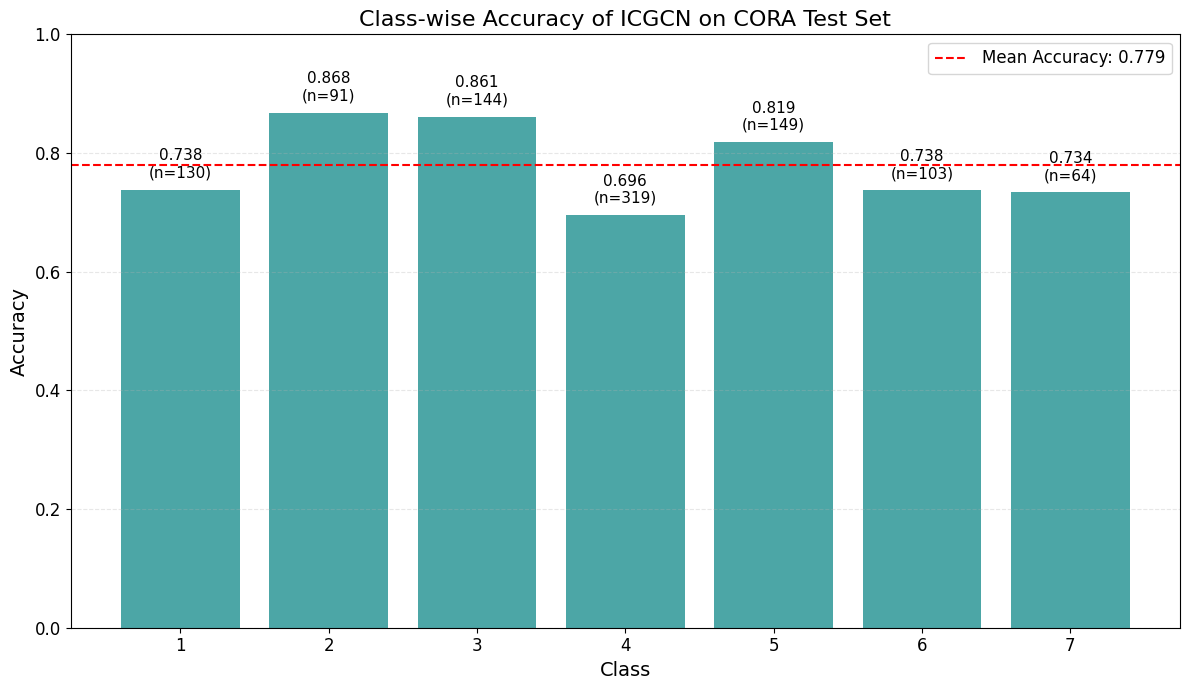

Class-wise accuracy:
Class 1: 0.7385 (n=130)
Class 2: 0.8681 (n=91)
Class 3: 0.8611 (n=144)
Class 4: 0.6959 (n=319)
Class 5: 0.8188 (n=149)
Class 6: 0.7379 (n=103)
Class 7: 0.7344 (n=64)
Mean accuracy: 0.7792


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

def plot_class_accuracy(model, data):
    """
    Plot class-wise accuracy with simple numeric labels

    Parameters:
    - model: Trained ICGCN model
    - data: PyG Data object containing CORA dataset
    """
    # Get predictions
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        pred = logits.argmax(dim=1)

    # Extract test predictions and labels
    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()

    # Calculate per-class accuracy
    num_classes = int(data.y.max().item() + 1)
    class_acc = np.zeros(num_classes)

    for i in range(num_classes):
        # Subset of test nodes with true class i
        class_mask = (y_true == i)
        if np.sum(class_mask) > 0:  # avoid division by zero
            # Accuracy for this class
            class_acc[i] = np.sum((y_pred == i) & class_mask) / np.sum(class_mask)

    # Create simple numeric class labels
    class_labels = [str(i+1) for i in range(num_classes)]

    # Create the plot
    plt.figure(figsize=(12, 7))

    # Create bar chart
    bars = plt.bar(class_labels, class_acc, color='teal', alpha=0.7)

    # Add a line for the mean accuracy
    mean_acc = np.mean(class_acc)
    plt.axhline(y=mean_acc, color='red', linestyle='--',
                label=f'Mean Accuracy: {mean_acc:.3f}')

    # Customize plot
    plt.ylim(0, 1.0)
    plt.title('Class-wise Accuracy of ICGCN on CORA Test Set', fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.legend(fontsize=12)

    # Add count of samples per class
    class_counts = [np.sum(y_true == i) for i in range(num_classes)]

    # Add values on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}\n(n={class_counts[i]})',
                ha='center', fontsize=11)

    plt.tight_layout()
    plt.savefig('icgcn_cora_class_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print results
    print("Class-wise accuracy:")
    for i in range(num_classes):
        print(f"Class {i+1}: {class_acc[i]:.4f} (n={class_counts[i]})")
    print(f"Mean accuracy: {mean_acc:.4f}")

    return class_acc, class_counts

# Plot class-wise accuracy
class_acc, class_counts = plot_class_accuracy(model, data)

# Pubmed Dataset


PubMed Dataset:
  Number of nodes: 19717
  Number of edges: 44324
  Number of features: 500
  Number of classes: 3
  Number of training nodes: 60
  Number of validation nodes: 500
  Number of test nodes: 1000

Training Input Convex GCN model on PubMed dataset...
Epoch: 010, Loss: 1.6223, Train: 0.4833, Val: 0.2920, Test: 0.3050
Epoch: 020, Loss: 1.1188, Train: 0.4000, Val: 0.4220, Test: 0.4130
Epoch: 030, Loss: 1.3031, Train: 0.3833, Val: 0.4240, Test: 0.4130
Epoch: 040, Loss: 1.1032, Train: 0.3833, Val: 0.4260, Test: 0.4150
Epoch: 050, Loss: 1.0708, Train: 0.3833, Val: 0.4280, Test: 0.4100
Epoch: 060, Loss: 1.1056, Train: 0.4167, Val: 0.4060, Test: 0.4020
Epoch: 070, Loss: 1.1660, Train: 0.5667, Val: 0.4340, Test: 0.4400
Epoch: 080, Loss: 1.0916, Train: 0.6167, Val: 0.4680, Test: 0.4790
Epoch: 090, Loss: 1.1113, Train: 0.7000, Val: 0.5060, Test: 0.5000
Epoch: 100, Loss: 1.1323, Train: 0.7500, Val: 0.5440, Test: 0.5330
Epoch: 110, Loss: 1.1608, Train: 0.7667, Val: 0.5720, Test: 0.5590

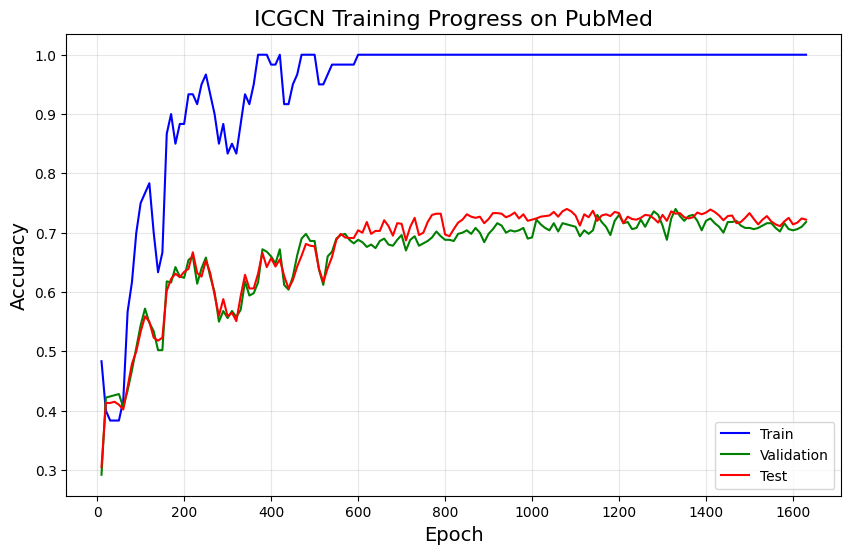

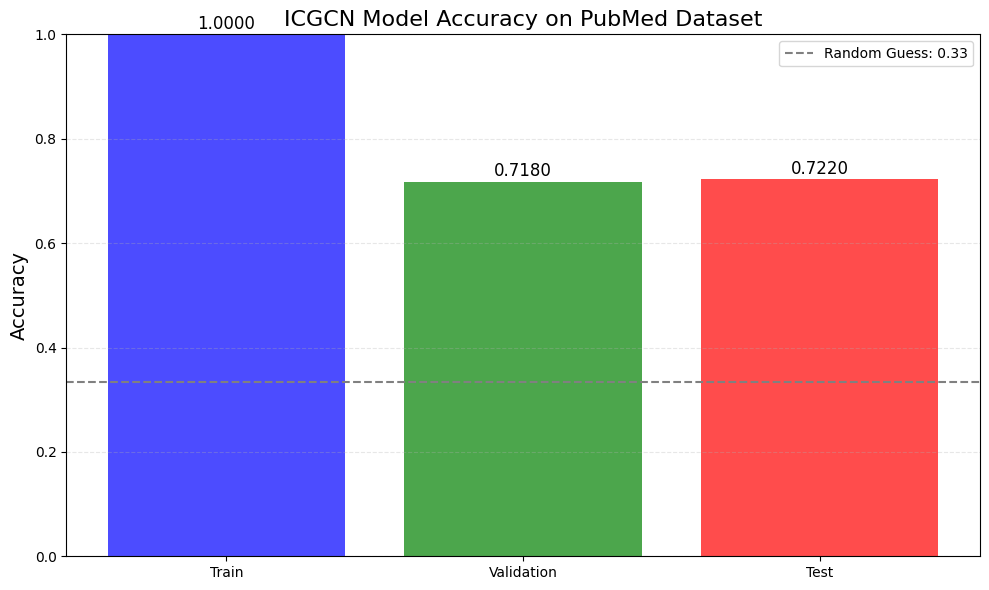

Train accuracy: 1.0000
Validation accuracy: 0.7180
Test accuracy: 0.7220


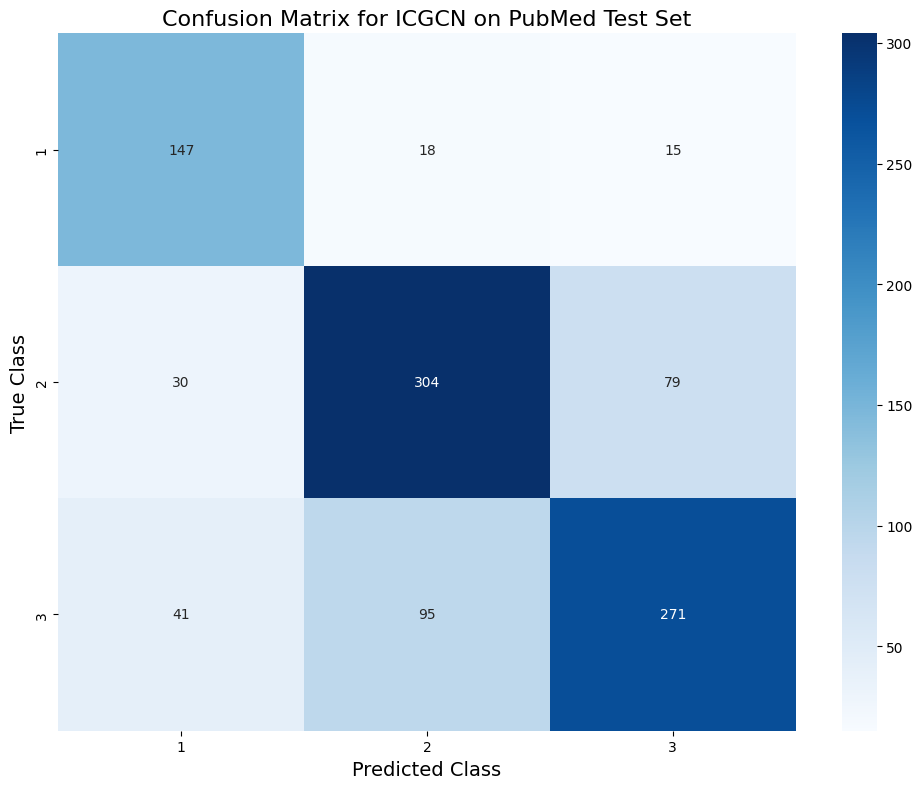

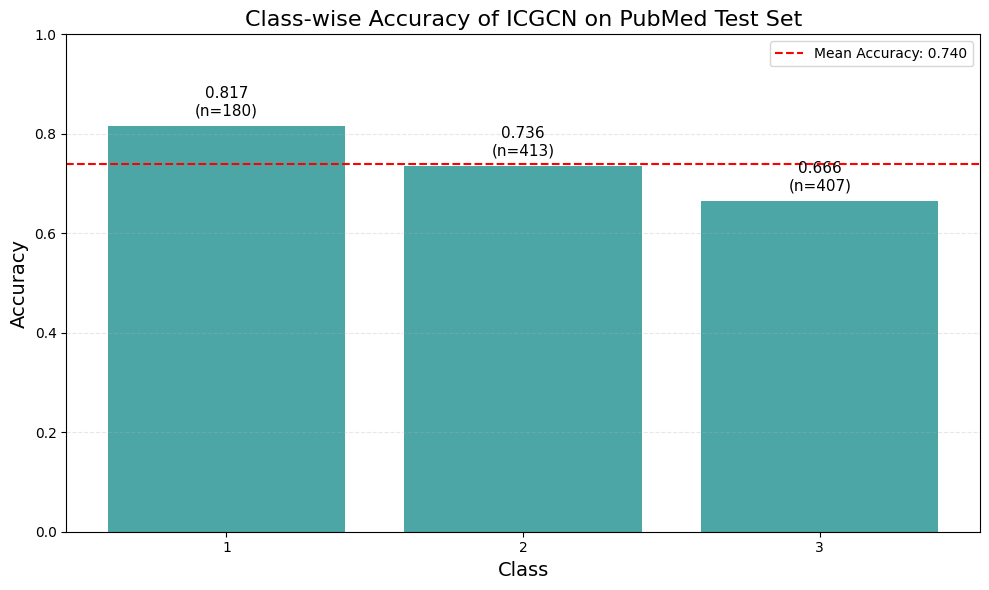

Class-wise accuracy:
Class 1: 0.8167 (n=180)
Class 2: 0.7361 (n=413)
Class 3: 0.6658 (n=407)
Mean accuracy: 0.7395


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import MessagePassing
from sklearn.metrics import accuracy_score, confusion_matrix

class ConvexGCNLayer(MessagePassing):
    """Graph Convolutional Layer with convexity constraints"""
    def __init__(self, in_channels, out_channels):
        super(ConvexGCNLayer, self).__init__(aggr='add')
        # Linear transformation for source nodes (weights constrained to be non-negative)
        self.weight = nn.Parameter(torch.Tensor(in_channels, out_channels))
        # Bias term
        self.bias = nn.Parameter(torch.Tensor(out_channels))

        # Skip connection transformation when dimensions don't match
        self.skip_proj = nn.Linear(in_channels, out_channels) if in_channels != out_channels else None

        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights to be small positive values (for stability)
        nn.init.uniform_(self.weight, 0.0, 0.1)
        nn.init.zeros_(self.bias)
        if self.skip_proj is not None:
            nn.init.xavier_uniform_(self.skip_proj.weight)
            nn.init.zeros_(self.skip_proj.bias)

    def forward(self, x, edge_index, edge_weight=None):
        # Store original input for skip connection
        original_x = x

        # Apply normalization like in standard GCN
        row, col = edge_index
        deg = torch.bincount(row)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Start propagating messages
        out = self.propagate(edge_index, x=x, norm=norm)

        # Apply skip connection with proper projection if needed
        if self.skip_proj is not None:
            skip = self.skip_proj(original_x)
        else:
            skip = original_x

        # Return the combination
        return out + skip

    def message(self, x_j, norm):
        # Apply normalization
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # Apply convex transformation with non-negative weights
        weight = torch.clamp(self.weight, min=0.0)

        # Matrix multiplication with non-negative weights to ensure convexity
        return F.linear(aggr_out, weight.t(), self.bias)


class InputConvexGCN(nn.Module):
    """Input Convex Graph Convolutional Network with regularization"""
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.5):
        super(InputConvexGCN, self).__init__()

        self.dropout = dropout

        # Feature dimensionality reduction to combat overfitting
        self.feature_proj = nn.Linear(in_channels, hidden_channels)

        # Input layer
        self.conv_first = ConvexGCNLayer(hidden_channels, hidden_channels)

        # Hidden layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers - 1):
            self.convs.append(ConvexGCNLayer(hidden_channels, hidden_channels))

        # Output layer
        self.classifier = nn.Linear(hidden_channels, out_channels)

        # Layer normalization
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden_channels) for _ in range(num_layers)
        ])

    def forward(self, x, edge_index):
        # Project features to lower dimension
        x = self.feature_proj(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # First layer
        x = self.conv_first(x, edge_index)
        x = self.layer_norms[0](x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Hidden layers
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = self.layer_norms[i+1](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Output layer
        x = self.classifier(x)

        return x


def train_icgcn(model, data, num_epochs=200, lr=0.005, weight_decay=5e-4, patience=30):
    """Train with early stopping"""
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    best_model = None
    patience_counter = 0

    train_accs = []
    val_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        # Training mode
        model.train()
        optimizer.zero_grad()

        # Forward pass
        logits = model(data.x, data.edge_index)

        # Compute loss (only for training nodes)
        loss = criterion(logits[data.train_mask], data.y[data.train_mask])

        # Backward pass
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Evaluation mode
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                # Forward pass
                logits = model(data.x, data.edge_index)
                pred = logits.argmax(dim=1)

                # Compute accuracies
                train_acc = accuracy_score(data.y[data.train_mask].cpu(),
                                          pred[data.train_mask].cpu())
                val_acc = accuracy_score(data.y[data.val_mask].cpu(),
                                        pred[data.val_mask].cpu())
                test_acc = accuracy_score(data.y[data.test_mask].cpu(),
                                         pred[data.test_mask].cpu())

                train_accs.append(train_acc)
                val_accs.append(val_acc)
                test_accs.append(test_acc)

                print(f'Epoch: {epoch+1:03d}, Loss: {loss.item():.4f}, '
                      f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

                # Early stopping logic
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model = model.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)

    return model, train_accs, val_accs, test_accs


def plot_accuracy(model, data):
    """Plot overall accuracy"""
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        pred = logits.argmax(dim=1)

    # Calculate accuracies
    train_acc = accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu())
    val_acc = accuracy_score(data.y[data.val_mask].cpu(), pred[data.val_mask].cpu())
    test_acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Dataset splits
    splits = ['Train', 'Validation', 'Test']
    accuracies = [train_acc, val_acc, test_acc]

    # Create bar plot
    bars = plt.bar(splits, accuracies, color=['blue', 'green', 'red'], alpha=0.7)

    # Add a horizontal line for random guessing (1/3 for PubMed)
    plt.axhline(y=1/3, color='gray', linestyle='--',
                label=f'Random Guess: {1/3:.2f}')

    # Customize plot
    plt.ylim(0, 1.0)
    plt.title('ICGCN Model Accuracy on PubMed Dataset', fontsize=16)
    plt.ylabel('Accuracy', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.legend()

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', fontsize=12)

    plt.tight_layout()
    plt.savefig('icgcn_pubmed_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f'Train accuracy: {train_acc:.4f}')
    print(f'Validation accuracy: {val_acc:.4f}')
    print(f'Test accuracy: {test_acc:.4f}')


def plot_confusion_matrix(model, data):
    """Plot confusion matrix with numeric class labels"""
    # Get predictions
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        pred = logits.argmax(dim=1)

    # Extract test predictions and labels
    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Get number of classes
    num_classes = int(data.y.max().item() + 1)
    class_labels = [str(i+1) for i in range(num_classes)]

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))

    # Create heatmap with raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)

    plt.title('Confusion Matrix for ICGCN on PubMed Test Set', fontsize=16)
    plt.xlabel('Predicted Class', fontsize=14)
    plt.ylabel('True Class', fontsize=14)

    plt.tight_layout()
    plt.savefig('icgcn_pubmed_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()


def plot_class_accuracy(model, data):
    """Plot class-wise accuracy with numeric labels"""
    # Get predictions
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        pred = logits.argmax(dim=1)

    # Extract test predictions and labels
    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()

    # Calculate per-class accuracy
    num_classes = int(data.y.max().item() + 1)
    class_acc = np.zeros(num_classes)

    for i in range(num_classes):
        # Subset of test nodes with true class i
        class_mask = (y_true == i)
        if np.sum(class_mask) > 0:
            # Accuracy for this class
            class_acc[i] = np.sum((y_pred == i) & class_mask) / np.sum(class_mask)

    # Create numeric class labels
    class_labels = [str(i+1) for i in range(num_classes)]

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Create bar chart
    bars = plt.bar(class_labels, class_acc, color='teal', alpha=0.7)

    # Add a line for the mean accuracy
    mean_acc = np.mean(class_acc)
    plt.axhline(y=mean_acc, color='red', linestyle='--',
                label=f'Mean Accuracy: {mean_acc:.3f}')

    # Customize plot
    plt.ylim(0, 1.0)
    plt.title('Class-wise Accuracy of ICGCN on PubMed Test Set', fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.legend()

    # Add count of samples per class
    class_counts = [np.sum(y_true == i) for i in range(num_classes)]

    # Add values on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}\n(n={class_counts[i]})',
                ha='center', fontsize=11)

    plt.tight_layout()
    plt.savefig('icgcn_pubmed_class_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print results
    print("Class-wise accuracy:")
    for i in range(num_classes):
        print(f"Class {i+1}: {class_acc[i]:.4f} (n={class_counts[i]})")
    print(f"Mean accuracy: {mean_acc:.4f}")


# Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility
    planetoi